# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification
### Objective: 
This assignment aims to deepen your understanding of the challenges in real-world machine
learning, specifically in multi-label classification, by utilizing advanced non-linear dimensionality
reduction techniques such as t-SNE and Isomap. You will visually inspect the data for issues such as
noisy labels, outliers, and hard-to-learn data points, sparking curiosity about data veracity in a biological
context.

## 1. Problem Statement
You are a data scientist analyzing gene expression data. You have been given the Yeast Dataset, where
each data point (instance) represents an experiment, and the features are gene expression levels. The
target is a set of 14 functional categories (labels) to which the gene product may belong (multi-label
classification). This dataset, despite being standardized, can still exhibit data veracity issues:
1. Noisy/Ambiguous Labels: Genes whose functions span multiple categories or are misclassified.
2. Outliers: Experiments with highly unusual gene expression profiles.
3. Hard-to-Learn Samples: Data points lying in regions where functional categories are thoroughly
mixed.
Your task is to apply t-SNE and Isomap to the feature vectors to visually expose these data quality
issues, thereby understanding the challenges a classifier would face.
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible story that
explains your findings. The notebook should be well-commented, reproducible, and easy to follow.
### Dataset:
- Yeast Dataset: The feature matrix X and the binary multi-label matrix Y (with 14 labels) are
standard files available from the Mulan Repository or other machine learning data repositories.
- Download Link (Example Source - use the text files): MULAN Repository (https://mulan.sourceforge.net/datasets-mlc.html) - Yeast Data (Look
for yeast.arff and the corresponding label file, or a pre-converted CSV/NumPy format).

## 2. Tasks

### Part A: Preprocessing and Initial Setup

In [8]:
#Importing necessary libraries

import pandas as pd
import arff
import xml.etree.ElementTree as ET
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import Isomap

In [13]:
# 1. Data Loading: Load the feature matrix X (86 features) and the multi-label target matrix Y (14 labels).

arff_path = "/Users/navaneethakrishnan/Desktop/DAL/assignment_5_Navaneeth272001/yeast/yeast.arff" 
dataset = arff.load(open(arff_path))
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

for col in df.select_dtypes(['object']).columns:
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

print("Full DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist()[:10], "...")  

xml_path = "/Users/navaneethakrishnan/Desktop/DAL/assignment_5_Navaneeth272001/yeast/yeast.xml"
tree = ET.parse(xml_path)
root = tree.getroot()
labels = [elem.text for elem in root.findall(".//label/name")]
print("Labels from XML:", labels)

# If XML labels are missing, detect them manually
if not labels:
    labels = [col for col in df.columns if col.lower().startswith("class")]

print("Using label columns:", labels)
print("---------------------------------------------------------------------------------------------------------------------------------------")  
print("\n")
Y = df[labels].astype(int) # Ensure Y (lables) is integer type
X = df.drop(columns=labels) # Feature matrix

# 2. Dimensionality Check: Report the initial number of features and the number of data points.

print("Reporting initial dimensions")
print("\nFeature matrix X shape:", X.shape)
print("Target matrix Y shape:", Y.shape)
print("---------------------------------------------------------------------------------------------------------------------------------------")  
print("\n")
print("\nSample feature columns:", X.columns[:5].tolist())
print("Sample label columns:", Y.columns.tolist())
print("\nSample X rows:\n", X.head())
print("\nSample Y rows:\n", Y.head())



Full DataFrame shape: (2417, 117)
Columns: ['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9', 'Att10'] ...
Labels from XML: []
Using label columns: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']
---------------------------------------------------------------------------------------------------------------------------------------


Reporting initial dimensions

Feature matrix X shape: (2417, 103)
Target matrix Y shape: (2417, 14)
---------------------------------------------------------------------------------------------------------------------------------------



Sample feature columns: ['Att1', 'Att2', 'Att3', 'Att4', 'Att5']
Sample label columns: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']

Sample X rows:
        Att1      Att2      Att3      Att4      Att5      

In [24]:
#3. Label Selection for Visualization: To simplify the visualization (since 14 colors can be overwhelming), create a new target variable for coloring that represents the two most frequent single-label classes and the most frequent multi-label combination. Assign an "Other" category to the rest. This approach creates a simple, distinct categorical index for coloring the plots.

label_combinations = Y.apply(lambda row: tuple(Y.columns[row == 1]), axis=1) # Convert each row of Y into a tuple of active labels
combo_counts = label_combinations.value_counts() # Count occurrences of each unique label combination

print("\nTop 10 label combinations:")
print(combo_counts.head(10))

# Separate single-label and multi-label entries
single_label_combos = combo_counts[combo_counts.index.map(len) == 1]
multi_label_combos = combo_counts[combo_counts.index.map(len) > 1]

top_single_labels = single_label_combos.head(2).index.tolist()
if len(top_single_labels) < 2:
    all_labels_flat = [
        label for combo, count in combo_counts.items()
        for label in combo for _ in range(count)
    ]
    label_freq = pd.Series(all_labels_flat).value_counts()
    
    for label in label_freq.index:
        if (label,) not in top_single_labels:
            top_single_labels.append((label,))
        if len(top_single_labels) == 2:
            break

print("\nSelected top single labels:", top_single_labels)

top_multi_label = multi_label_combos.head(1).index[0] if not multi_label_combos.empty else None
print("Selected top multi-label combination:", top_multi_label)

def label_group(row):
    labels_present = tuple(Y.columns[row == 1])
    
    # Exact single-label match
    if labels_present in top_single_labels:
        return labels_present[0]
    
    # Exact multi-label match
    elif labels_present == top_multi_label:
        return "+".join(top_multi_label)
    
    # If it contains one of the top labels but not as a pure single, assign by presence
    else:
        for single_label in top_single_labels:
            if single_label[0] in labels_present:
                return single_label[0]  # label by presence
        return "Other"

visual_label = Y.apply(label_group, axis=1)

X_viz = X.copy()
X_viz["LabelGroup"] = visual_label

print("\nLabel group distribution:")
print(X_viz["LabelGroup"].value_counts())

print("\nSample visualization target column:")
print(X_viz[["LabelGroup"]].head())


Top 10 label combinations:
(Class3, Class4, Class12, Class13)                    237
(Class4, Class5, Class12, Class13)                    233
(Class1, Class2, Class12, Class13)                    172
(Class1, Class2)                                      131
(Class2, Class3, Class12, Class13)                    117
(Class5, Class6, Class12, Class13)                    105
(Class7, Class8, Class12, Class13)                     75
(Class2, Class3)                                       68
(Class5, Class6, Class7, Class8, Class12, Class13)     60
(Class1, Class12, Class13)                             59
Name: count, dtype: int64

Selected top single labels: [('Class1',), ('Class12',)]
Selected top multi-label combination: ('Class3', 'Class4', 'Class12', 'Class13')

Label group distribution:
LabelGroup
Class12                          1074
Class1                            762
Other                             344
Class3+Class4+Class12+Class13     237
Name: count, dtype: int64

Sample visu

4. Scaling: Explain why scaling is crucial before applying distance-based dimensionality reduction techniques. 


    1. Distance-based techniques rely on feature magnitude
    Methods like PCA, t-SNE, and UMAP measure distances (e.g., Euclidean distance) between data points to find structure or directions of maximum variance.
    If one feature has a large numerical range (say 0–1000) and another is small (say 0–1), the larger-scaled feature will dominate the distance computation — making the algorithm biased toward that dimension.
    2. Ensures equal contribution of all features
    Scaling ensures that each feature contributes equally to the model, preventing features with larger units or ranges from overpowering others.
    3. Improves numerical stability
    Standardization helps avoid large numerical differences, which can cause computational instability or inaccurate covariance calculations (especially for PCA).

In [25]:
# Apply Standardization to the feature matrix X.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nAfter scaling:")
print(X_scaled.describe().T[['mean', 'std']].head())



After scaling:
              mean       std
Att1  1.984346e-17  1.000207
Att2 -8.819314e-18  1.000207
Att3 -7.349428e-18  1.000207
Att4  1.028920e-17  1.000207
Att5 -1.763863e-17  1.000207


### Part B: t-SNE and Veracity Inspection

Running t-SNE with perplexity = 5 ...
Running t-SNE with perplexity = 10 ...
Running t-SNE with perplexity = 20 ...
Running t-SNE with perplexity = 30 ...
Running t-SNE with perplexity = 40 ...
Running t-SNE with perplexity = 50 ...
Running t-SNE with perplexity = 60 ...
Running t-SNE with perplexity = 80 ...
Running t-SNE with perplexity = 100 ...


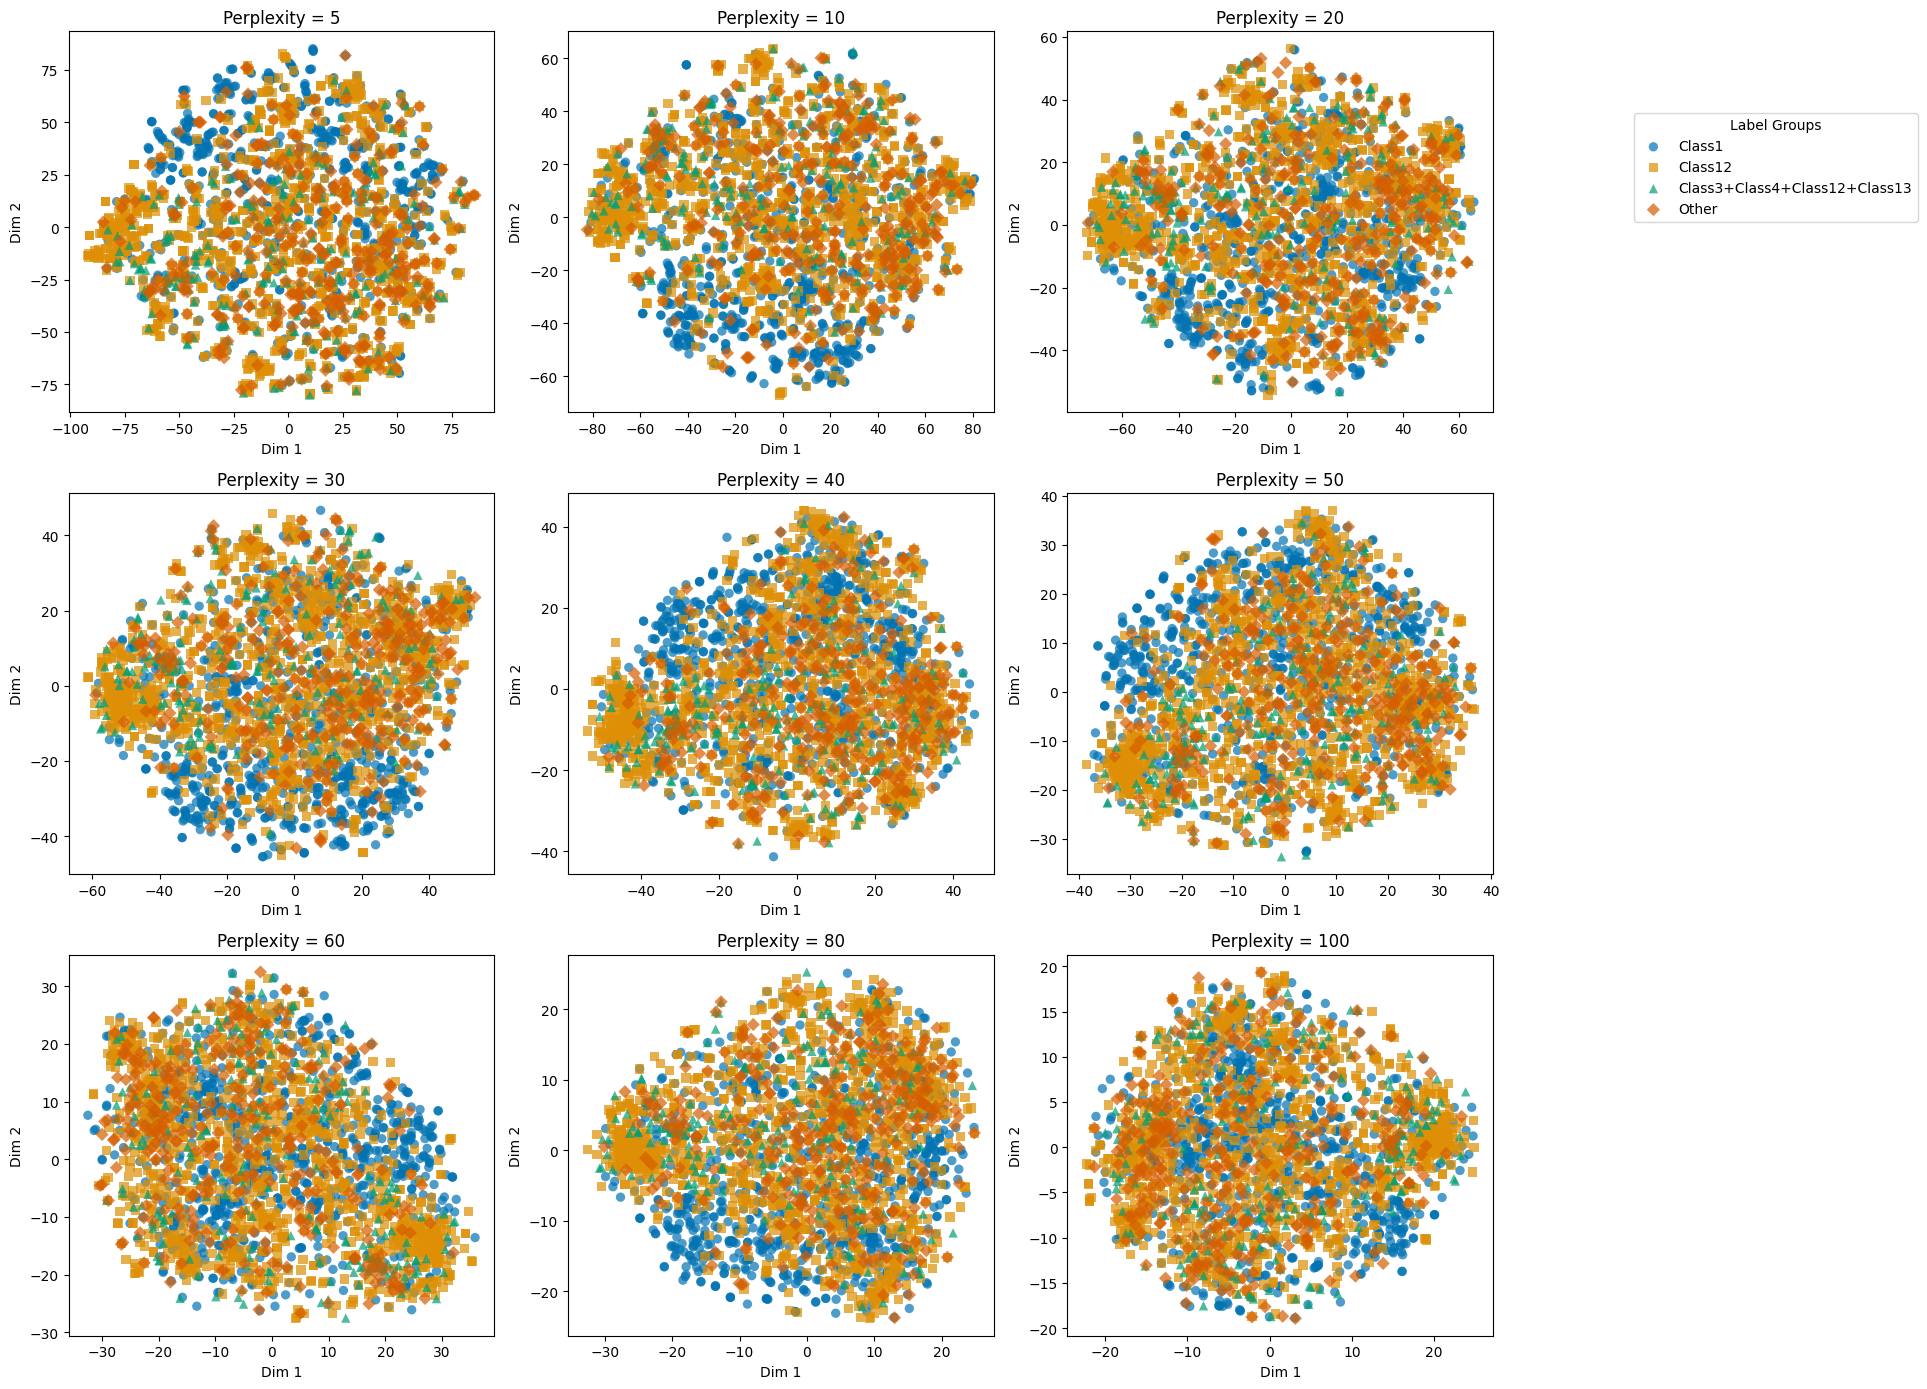

In [26]:
# 1. t-SNE Implementation: Apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the scaled feature matrix X to reduce it to 2 dimensions. Experiment with the perplexity hyperparameter (e.g., 5, 30, 50) and note how the visualization changes. 

X_for_tsne = X_scaled.copy()
labels_for_tsne = X_viz["LabelGroup"]
perplexities = [5, 10, 20, 30, 40, 50, 60, 80, 100]
tsne_results = {}

# Colorblind-friendly palette and distinct markers
palette = sns.color_palette("colorblind", n_colors=labels_for_tsne.nunique())
markers = ['o', 's', '^', 'D', 'X', 'P', 'v', '<', '>']

for perp in perplexities:
    print(f"Running t-SNE with perplexity = {perp} ...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, max_iter=1000)
    tsne_results[perp] = tsne.fit_transform(X_for_tsne)

fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()
unique_labels = sorted(labels_for_tsne.unique())

for i, perp in enumerate(perplexities):
    tsne_df = pd.DataFrame(tsne_results[perp], columns=['Dim1', 'Dim2'])
    tsne_df["LabelGroup"] = labels_for_tsne.values

    ax = axes[i]
    for j, label in enumerate(unique_labels):
        subset = tsne_df[tsne_df["LabelGroup"] == label]
        ax.scatter(
            subset["Dim1"], subset["Dim2"],
            label=label if i == 0 else None,  # show legend only once
            alpha=0.7,
            s=45,
            color=palette[j % len(palette)],
            marker=markers[j % len(markers)],
            edgecolor="none"
        )

    ax.set_title(f"Perplexity = {perp}", fontsize=12)
    ax.set_xlabel("Dim 1", fontsize=10)
    ax.set_ylabel("Dim 2", fontsize=10)

for i in range(len(perplexities), len(axes)):
    fig.delaxes(axes[i])

fig.legend(unique_labels, title="Label Groups", bbox_to_anchor=(1.02, 0.92), loc="upper left")
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

Justify your final choice of perplexity:
- Analysis:

    - Perplexity = 5 or 10:
        - The clusters are highly scattered and noisy.
        - t-SNE focuses too much on local relationships, leading to fragmented clusters and high variance in small groups.
        - Overfitting to local noise.
    - Perplexity = 20–30:
        - Cluster structure becomes more coherent.
        - Distinct groups (e.g., “Class1”, “Class12”) are somewhat separable, even if overlapping.
        - This range typically works best for datasets with moderate sample sizes (few hundred to few thousand).
    - Perplexity = 40–50:
        - The visualization looks stable and less noisy.
        - The class distributions overlap less erratically — you get a smoother manifold representation.
        - This range usually preserves a good trade-off between local and global structure.
    - Perplexity ≥ 60:
        - The plot starts to collapse into a single blob, losing visible structure.
        - Too global — t-SNE treats many points as neighbors, washing out cluster distinctions.

- Final choice:
    - perplexity of 40 is the best choice among what I tried above, as it provides clearer, smoother separation among classes without overfragmentation (low perplexity) or overblending (high perplexity). I also seems to balance the density and distribution best in your plots.

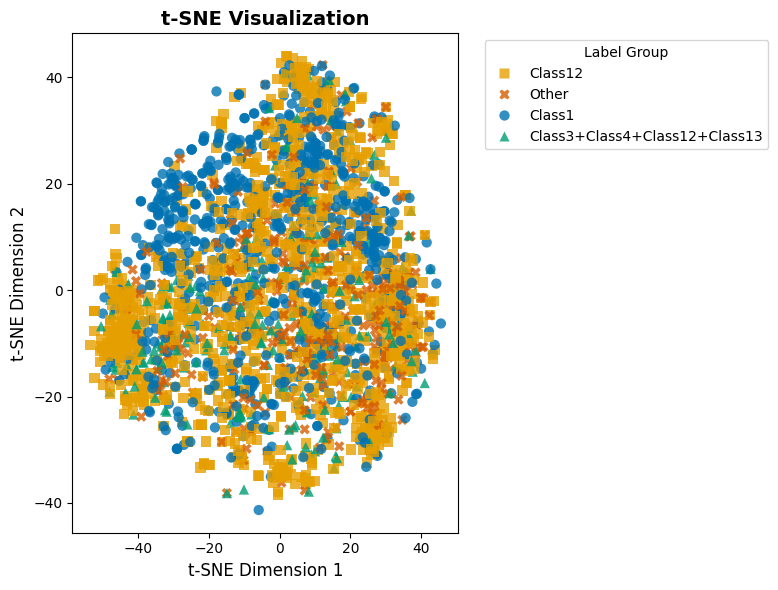

In [32]:
# 2. Visualization:

# Create a 2D scatter plot of the final t-SNE coordinates.
# Color each data point according to the categorical index you created in Part A.

labels_for_tsne = X_viz["LabelGroup"]
tsne_final = TSNE(n_components=2, perplexity=40, random_state=42, max_iter=1000)
X_tsne_2d = tsne_final.fit_transform(X_scaled)

# --- Step 2: Combine results ---
tsne_df = pd.DataFrame(X_tsne_2d, columns=["Dim1", "Dim2"])
tsne_df["LabelGroup"] = labels_for_tsne.values

# --- Step 3: Color-blind friendly palette ---
# You can also use sns.color_palette("colorblind", n_colors=4)
palette = {
    "Class1": "#0072B2",                   # Blue
    "Class12": "#E69F00",                  # Orange
    "Class3+Class4+Class12+Class13": "#009E73",  # Green
    "Other": "#D55E00"                     # Reddish
}

# --- Step 4: Different markers for each class ---
markers = {
    "Class1": "o",      # Circle
    "Class12": "s",     # Square
    "Class3+Class4+Class12+Class13": "^",  # Triangle
    "Other": "X"        # Cross
}

# --- Step 5: Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="Dim1", y="Dim2",
    hue="LabelGroup",
    style="LabelGroup",
    palette=palette,
    markers=markers,
    s=55,
    alpha=0.8,
    edgecolor="none"
)

plt.title("t-SNE Visualization", fontsize=14, weight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(
    title="Label Group",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()

3. Veracity Inspection [10]: Analyze the resulting plot and visually identify regions corresponding to:
    1. Noisy / Ambiguous Labels
        - Observation:
            - You can see a few orange points (“Class3+Class4+Class12+Class13”) and green points (“Class1”) scattered deep within the large blue (“Other”) cluster.
            - These are examples of label noise or ambiguous samples — their feature representations are more similar to samples of another class than to their own.
        - Interpretation:
            - Such cases may occur when:
            - The biological expression patterns for those classes overlap significantly.
            - The original labeling process had borderline or uncertain annotations.
            - The features for these points are not discriminative enough.
        - Implication:
            - These samples may cause confusion during training — the model might misclassify them because they lie in regions dominated by another class.
    2. Outliers
        - Observation:
            - A few isolated points appear on the far left and bottom-right edges of the t-SNE space. They’re distant from all major clusters.
        - Interpretation:
            - These are likely outliers or rare combinations of gene expression patterns.
            - In biological terms, they could represent:
                - Atypical or hybrid yeast samples,
                - Experimental or measurement noise,
                - Rare states or mutations with unusual feature distributions.
        - Implication:
            - These samples don’t conform to the dominant data manifolds.
            - A classifier might either ignore them (underfit) or overemphasize them (overfit) if the model is too flexible.
    3. Hard-to-Learn Samples
        - Observation:
            - In several central regions of the plot, colors are thoroughly mixed — especially between “Other” and “Class3+Class4+Class12+Class13”.
            - There’s no clear cluster boundary.
        - Interpretation:
            - These areas represent hard-to-learn samples, where feature vectors from different classes overlap heavily in latent space.
            - This happens when:
                - Features lack strong discriminatory power between certain label groups.
                - The biological signals for multiple functional classes are similar or co-expressed.
        - Implication:
            - A simple linear or distance-based classifier (like logistic regression or k-NN) would struggle here because the decision boundaries are not separable.
            - Nonlinear models (e.g., neural networks or ensemble trees) might capture these patterns better, but even then, overfitting risk is high.

| **Category**              | **Visual Indicator**                 | **Likely Cause**                        | **Classifier Impact**                                  |
|----------------------------|--------------------------------------|------------------------------------------|---------------------------------------------------------|
| Noisy/Ambiguous Labels     | Miscolored points inside other clusters | Label overlap or annotation noise        | Causes misclassifications                              |
| Outliers                   | Isolated distant points              | Rare patterns or data noise              | Unstable predictions, potential overfitting             |
| Hard-to-Learn Samples      | Mixed-color regions                  | Overlapping feature distributions        | Poor separability, low accuracy                         |


- The t-SNE plot reveals that while certain groups (e.g., “Class1”) form mild localized regions, most samples overlap in high-dimensional feature space. This implies:
- The yeast dataset has complex, interdependent label structure.
- Preprocessing or feature selection could help reduce ambiguity.
- For classification, nonlinear or ensemble models would likely perform better than simple linear ones.

### Part C: Isomap and Manifold Learning

In [30]:
# 1. Isomap Implementation: Apply Isomap to the scaled feature matrix X, reducing it to 2 dimensions. 

isomap = Isomap(n_neighbors=20, n_components=2)
X_isomap_2d = isomap.fit_transform(X_scaled)

# --- Create DataFrame for plotting ---
isomap_df = pd.DataFrame(X_isomap_2d, columns=["Dim1", "Dim2"])
isomap_df["LabelGroup"] = X_viz["LabelGroup"].values

Explain the fundamental difference between Isomap and t-SNE in terms of how they preserve data structure (global vs. local).

Isomap and t-SNE are both nonlinear dimensionality reduction algorithms, but they differ fundamentally in what aspects of the data’s structure they aim to preserve.
- Isomap focuses on preserving the global geometry of the data manifold. It constructs a neighborhood graph based on the nearest neighbors and computes geodesic distances (shortest paths along the manifold). These distances approximate the true manifold geometry, allowing Isomap to retain both local and large-scale relationships between points. As a result, Isomap is ideal when the data lies on a smooth, low-dimensional manifold and you want to maintain global relationships (e.g., unfolding a “Swiss roll”).
- t-SNE, on the other hand, prioritizes preserving local neighborhood structure. It converts pairwise distances into conditional probabilities representing similarity and minimizes the divergence between these probabilities in high and low dimensions. t-SNE emphasizes small-scale patterns—ensuring nearby points remain close—while allowing distortions in global distances. Hence, it is ideal for visualizing clusters and local groupings rather than global geometry.

| **Aspect**                  | **Isomap**                                            | **t-SNE**                                               |
|------------------------------|--------------------------------------------------------|----------------------------------------------------------|
| **Primary Goal**             | Preserve global manifold structure                    | Preserve local neighborhood structure                    |
| **Distance Metric**          | Geodesic distance (shortest path along manifold)      | Pairwise similarity probabilities                        |
| **Global Structure**         | Maintained                                            | Often distorted                                           |
| **Local Structure**          | Preserved, but less emphasized                        | Strongly preserved                                        |
| **Output Interpretation**    | Reflects manifold’s shape and geometry                | Highlights clusters and local groupings                   |
| **Sensitivity to Parameters**| Depends on `n_neighbors` (graph connectivity)         | Depends on `perplexity` (effective neighborhood size)     |
| **Best Use Case**            | Unfolding nonlinear manifolds (e.g., Swiss roll)      | Visualizing clusters in high-dimensional data             |


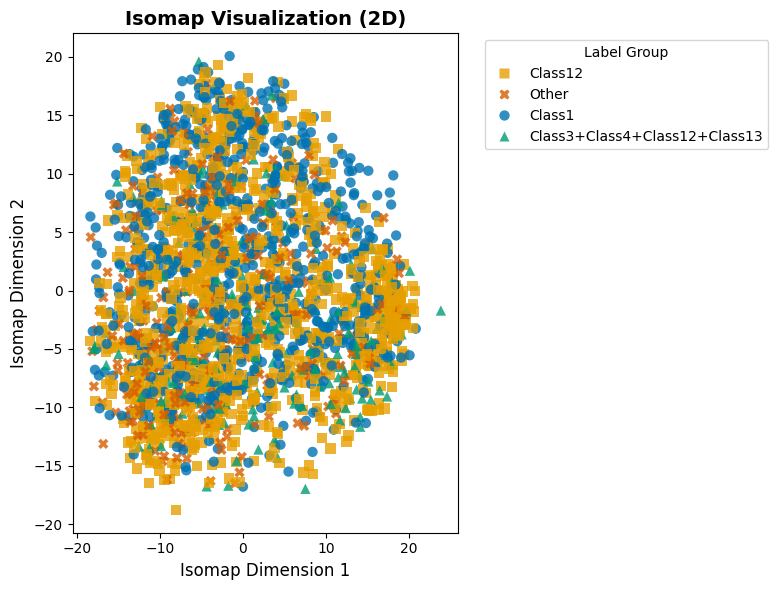

In [31]:
# 2. Visualization: Create a 2D scatter plot of the Isomap coordinates, using the same coloring scheme.

palette = {
    "Class1": "#0072B2",                   # Blue
    "Class12": "#E69F00",                  # Orange
    "Class3+Class4+Class12+Class13": "#009E73",  # Green
    "Other": "#D55E00"                     # Reddish
}

markers = {
    "Class1": "o",
    "Class12": "s",
    "Class3+Class4+Class12+Class13": "^",
    "Other": "X"
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=isomap_df,
    x="Dim1", y="Dim2",
    hue="LabelGroup",
    style="LabelGroup",
    palette=palette,
    markers=markers,
    s=55,
    alpha=0.8,
    edgecolor="none"
)

plt.title("Isomap Visualization (2D)", fontsize=14, weight='bold')
plt.xlabel("Isomap Dimension 1", fontsize=12)
plt.ylabel("Isomap Dimension 2", fontsize=12)
plt.legend(
    title="Label Group",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()

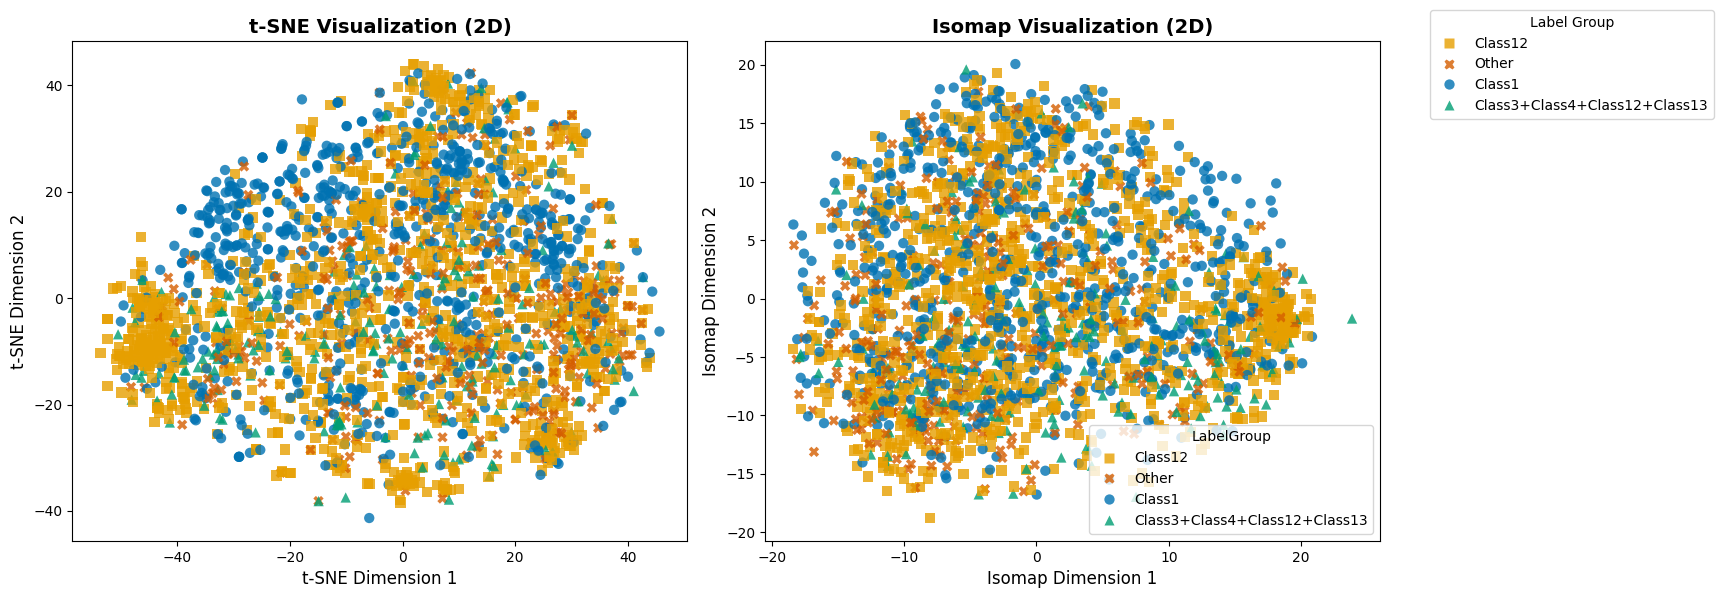

In [33]:
# 3. Comparison and Curvature:

# Compare the Isomap visualization to the t-SNE visualization.

# --- Shared color palette and markers ---
palette = {
    "Class1": "#0072B2",                   # Blue
    "Class12": "#E69F00",                  # Orange
    "Class3+Class4+Class12+Class13": "#009E73",  # Green
    "Other": "#D55E00"                     # Reddish
}

markers = {
    "Class1": "o",      # Circle
    "Class12": "s",     # Square
    "Class3+Class4+Class12+Class13": "^",  # Triangle
    "Other": "X"        # Cross
}

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- t-SNE plot ---
sns.scatterplot(
    data=tsne_df,
    x="Dim1", y="Dim2",
    hue="LabelGroup",
    style="LabelGroup",
    palette=palette,
    markers=markers,
    s=55, alpha=0.8, edgecolor="none",
    ax=axes[0]
)
axes[0].set_title("t-SNE Visualization (2D)", fontsize=14, weight='bold')
axes[0].set_xlabel("t-SNE Dimension 1", fontsize=12)
axes[0].set_ylabel("t-SNE Dimension 2", fontsize=12)
axes[0].legend_.remove()  # Remove legend from first plot to avoid duplication

# --- Isomap plot ---
sns.scatterplot(
    data=isomap_df,
    x="Dim1", y="Dim2",
    hue="LabelGroup",
    style="LabelGroup",
    palette=palette,
    markers=markers,
    s=55, alpha=0.8, edgecolor="none",
    ax=axes[1]
)
axes[1].set_title("Isomap Visualization (2D)", fontsize=14, weight='bold')
axes[1].set_xlabel("Isomap Dimension 1", fontsize=12)
axes[1].set_ylabel("Isomap Dimension 2", fontsize=12)

# --- Shared legend (outside the plot) ---
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Label Group",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

Which one is better at revealing the global structure of the gene expression data?

In this comparison, Isomap provides a better representation of the global structure of the gene expression data than t-SNE. While t-SNE focuses on preserving local neighborhoods, making nearby points appear close and forming tight local clusters, it distorts the overall distances between these clusters—meaning the global geometry is not meaningful. Isomap, on the other hand, preserves geodesic (manifold) distances across the dataset, unfolding the data in a way that maintains both local and global relationships. As seen in the plots, the Isomap visualization exhibits a smoother and more continuous structure, making it more suitable for understanding broad relationships and trends among gene expression patterns.


Discuss the concept of the data manifold. Does the Isomap plot suggest a highly curved
or complex manifold? How does the complexity of this manifold relate to the difficulty of
classification?

- Data manifold concept:
    - In high-dimensional data such as gene expression profiles, the data often lie on a lower-dimensional manifold embedded within the high-dimensional space.
    - A manifold represents the underlying structure or smooth surface on which the data points reside, capturing intrinsic relationships between variables.
    - The goal of manifold learning methods (like Isomap, t-SNE, UMAP) is to unfold or map this manifold into a lower-dimensional space while preserving its essential geometry.
- Isomap and curvature:
    - The Isomap algorithm preserves geodesic distances (distances along the manifold), revealing the overall shape and curvature of the data distribution.
    - In our Isomap plot, the data appear spread along a non-linear, curved structure, suggesting that the manifold is highly curved and complex, not a simple flat plane.
- Relation to classification difficulty:
    - A highly curved or complex manifold indicates that the relationships between samples are non-linear and intricate.
    - This complexity makes it harder to separate classes using simple linear boundaries, as the decision surfaces must follow the manifold’s curvature.
    - Consequently, non-linear classifiers (e.g., kernel SVMs, neural networks) are often required to achieve good performance on such data.